In [1]:
!pwd
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.executable

/81908/jupyter_notebook/tf_2_work/bike-sharing/notebook


'/usr/local/bin/python3.7'

https://www.kaggle.com/lasmith/house-price-regression-with-lightgbm/data

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
import os
import datetime

In [3]:
df_train = pd.read_csv("../data/bike-sharing-demand/train.csv", 
                       dtype={'season': 'category',
                              'holiday': 'category',
                              'workingday': 'category',
                              'weather': 'category'},
                       parse_dates=['datetime'])
df_test = pd.read_csv("../data/bike-sharing-demand/test.csv", 
                       dtype={'season': 'category',
                              'holiday': 'category',
                              'workingday': 'category',
                              'weather': 'category'},
                      parse_dates=['datetime'])

display(df_train.head())
display(df_train.info())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  category      
 3   workingday  10886 non-null  category      
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: category(4), datetime64[ns](1), float64(3), int64(4)
memory usage: 723.1 KB


None

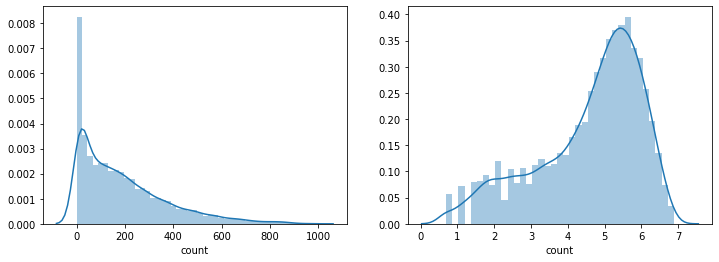

In [4]:
fig, ax = plt.subplots(1,2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(df_train['count'], ax=ax[0])
sns.distplot(np.log(df_train[('count')]+1), ax=ax[1])

In [5]:
def fill_missing(df, cols, val):
    """ Fill with the supplied val """
    for col in cols:
        df[col] = df[col].fillna(val)

        
def fill_missing_with_mode(df, cols):
    """ Fill with the mode """
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])

        
def addlogs(res, cols):
    """ Log transform feature list"""
    m = res.shape[1]
    for c in cols:
        res = res.assign(newcol = pd.Series(np.log(1.01+res[c])).values)   
        res.columns.values[m] = c + '_log'
        m += 1
    return res


def bin_col(df_train, df_test, bin_col='windspeed', n_bin=8, target_col='count'):
    """ ビニングで数値列をカテゴリ型に変換 """
    df = pd.concat([df_train, df_test], ignore_index=True).sort_values(by=['datetime']).reset_index(drop=True)
    df[bin_col + '_category'] = pd.cut(df[bin_col], n_bin, labels=False)
    df_train = df[df[target_col].notnull()].reset_index(drop=True)
    df_test = df[df[target_col].isnull()].reset_index(drop=True)
    df[bin_col + '_category'] = df[bin_col + '_category'].astype('category')  # カテゴリ型に変換
    return df_train, df_test


def diff_shift(df_train, df_test, cols, n_row=24, target_col='count'):
    """ 差分列追加 """
    df = pd.concat([df_train, df_test], ignore_index=True).sort_values(by=['datetime']).reset_index(drop=True)
    for c in cols:
        df[c + '_diff_shift'] = (df[c] - df[c].shift(n_row)) / df[c].shift(n_row)
    df_train = df[df[target_col].notnull()].reset_index(drop=True)
    df_test = df[df[target_col].isnull()].reset_index(drop=True)
    return df_train, df_test


def add_target_shift(df_train, df_test, n_row=24 * 12, target_col='count'):
    """ (n_row/24)日前の目的変数列を追加 """
    df = pd.concat([df_train, df_test], ignore_index=True).sort_values(by=['datetime']).reset_index(drop=True)
    
    shift_targets = []
    for i, x in enumerate(df['datetime']):
        shift_target = df[df['datetime'] == x - datetime.timedelta(days=(n_row // 24))][target_col]

        if len(shift_target) == 0:
            shift_target = None
        else:
            shift_target = shift_target.values[0]
            
        #print(i, shift_target, x)
        shift_targets.append(shift_target)
        
    df[target_col + '_shift'] = shift_targets
        
    df_train = df[df[target_col].notnull()].reset_index(drop=True)
    df_test = df[df[target_col].isnull()].reset_index(drop=True)
    return df_train, df_test

In [6]:
logcols = ['temp', 'atemp', 'humidity', 'windspeed']
df_train = addlogs(df_train, logcols)
df_test = addlogs(df_test, logcols)

In [7]:
df_train, df_test = bin_col(df_train, df_test, 
                            bin_col='windspeed', 
                            n_bin=8, 
                            target_col='count')
#print(df_train['windspeed_cate'].value_counts())
#print(df_test['windspeed_cate'].value_counts())

In [8]:
shiftcols = ['temp', 'atemp', 'humidity', 'windspeed']
df_train, df_test = diff_shift(df_train, df_test, shiftcols, 
                               n_row=24, 
                               target_col='count')

In [9]:
df_train, df_test = add_target_shift(df_train, df_test, 
                                     n_row=24 * 12, 
                                     target_col='count')

In [10]:
df_train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,temp_log,atemp_log,humidity_log,windspeed_log,windspeed_category,temp_diff_shift,atemp_diff_shift,humidity_diff_shift,windspeed_diff_shift,count_shift
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,...,2.384165,2.734692,4.406841,0.009950,0,NaN,NaN,NaN,NaN,NaN
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,...,2.305581,2.684099,4.394573,0.009950,0,NaN,NaN,NaN,NaN,NaN
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,...,2.305581,2.684099,4.394573,0.009950,0,NaN,NaN,NaN,NaN,NaN
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,...,2.384165,2.734692,4.330865,0.009950,0,NaN,NaN,NaN,NaN,NaN
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,...,2.384165,2.734692,4.330865,0.009950,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7.0,...,2.808800,3.030375,3.932022,3.296307,3,0.000000,0.000000,0.086957,0.000000,352.0
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10.0,...,2.758109,2.914251,4.060615,2.773295,2,0.000000,0.045605,0.140000,-0.117462,241.0
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4.0,...,2.704711,2.828496,4.127296,2.773295,2,-0.055556,-0.086944,0.220000,0.000000,171.0
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12.0,...,2.704711,2.914251,4.127296,1.947794,0,0.000000,0.045605,0.244898,inf,165.0


In [11]:
df_test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,temp_log,atemp_log,humidity_log,windspeed_log,windspeed_category,temp_diff_shift,atemp_diff_shift,humidity_diff_shift,windspeed_diff_shift,count_shift
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,NaN,...,2.457021,2.515678,4.043227,3.296307,3,0.181818,-0.166483,-0.397849,inf,25.0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,...,2.457021,2.684099,4.043227,0.009950,0,0.181818,0.000000,-0.397849,NaN,16.0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,NaN,...,2.457021,2.684099,4.043227,0.009950,0,0.181818,0.199736,-0.397849,-1.000000,16.0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,...,2.457021,2.631169,4.043227,2.485856,1,0.181818,0.133304,-0.397849,0.222636,7.0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,NaN,...,2.457021,2.631169,4.043227,2.485856,1,0.181818,0.133304,-0.397849,0.222636,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,...,2.457021,2.631169,4.111038,2.485856,1,-0.235294,-0.291529,-0.016393,inf,336.0
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,...,2.457021,2.631169,4.111038,2.485856,1,0.181818,0.307614,0.276596,-0.500000,241.0
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,...,2.457021,2.631169,4.111038,2.485856,1,0.300000,0.214521,0.176471,0.000000,168.0
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,...,2.457021,2.684099,4.043227,2.303395,1,0.300000,0.384264,0.018182,-0.307732,129.0


In [12]:
def dummy_encode(in_df_train, in_df_test):
    """ ダミー化してonehot化 """
    df_train = in_df_train
    df_test = in_df_test
    categorical_feats = [
        f for f in df_train.columns if df_train[f].dtype.name in ['object', 'category', 'bool']
    ]
    print(categorical_feats)
    for f_ in categorical_feats:
        prefix = f_
        df_train = pd.concat([df_train, pd.get_dummies(df_train[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        df_test = pd.concat([df_test, pd.get_dummies(df_test[f_], prefix=prefix)], axis=1).drop(f_, axis=1)
        #df_test = fix_missing_cols(df_train, df_test)
    return df_train, df_test

In [13]:
df_train, df_test = dummy_encode(df_train, df_test)
print("Shape train: %s, test: %s" % (df_train.shape, df_test.shape))

['season', 'holiday', 'workingday', 'weather']
Shape train: (10886, 30), test: (6493, 30)


In [14]:
y = df_train['count']
df_train = df_train.drop(['casual', 'registered', 'count'], axis=1)

In [17]:
display(df_train.head())
display(df_train.info())

,datetime,temp,atemp,humidity,windspeed,temp_log,atemp_log,humidity_log,windspeed_log,windspeed_category,...,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_1,weather_2,weather_3,weather_4
0,2011-01-01 00:00:00,9.84,14.395,81,0.0,2.384165,2.734692,4.406841,0.00995,0,...,0,0,1,0,1,0,1,0,0,0
1,2011-01-01 01:00:00,9.02,13.635,80,0.0,2.305581,2.684099,4.394573,0.00995,0,...,0,0,1,0,1,0,1,0,0,0
2,2011-01-01 02:00:00,9.02,13.635,80,0.0,2.305581,2.684099,4.394573,0.00995,0,...,0,0,1,0,1,0,1,0,0,0
3,2011-01-01 03:00:00,9.84,14.395,75,0.0,2.384165,2.734692,4.330865,0.00995,0,...,0,0,1,0,1,0,1,0,0,0
4,2011-01-01 04:00:00,9.84,14.395,75,0.0,2.384165,2.734692,4.330865,0.00995,0,...,0,0,1,0,1,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              10886 non-null  datetime64[ns]
 1   temp                  10886 non-null  float64       
 2   atemp                 10886 non-null  float64       
 3   humidity              10886 non-null  int64         
 4   windspeed             10886 non-null  float64       
 5   temp_log              10886 non-null  float64       
 6   atemp_log             10886 non-null  float64       
 7   humidity_log          10886 non-null  float64       
 8   windspeed_log         10886 non-null  float64       
 9   windspeed_category    10886 non-null  int64         
 10  temp_diff_shift       10862 non-null  float64       
 11  atemp_diff_shift      10862 non-null  float64       
 12  humidity_diff_shift   10862 non-null  float64       
 13  windspeed_diff_s

None

In [16]:
def train_val_split(df_train, day_th=16):
    df_train = df_train[df_train['datetime'].apply(lambda x: x if x.day in range(1, day_th) else None).dropna()]
    df_val = df_train[df_train['datetime'].apply(lambda x: x if x.day in range(day_th, 31) else None).dropna()]
    return df_train, df_val
df_train, df_val = train_val_split(df_train, day_th=16)

KeyError: "None of [DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',\n               '2011-01-01 02:00:00', '2011-01-01 03:00:00',\n               '2011-01-01 04:00:00', '2011-01-01 05:00:00',\n               '2011-01-01 06:00:00', '2011-01-01 07:00:00',\n               '2011-01-01 08:00:00', '2011-01-01 09:00:00',\n               ...\n               '2012-12-15 14:00:00', '2012-12-15 15:00:00',\n               '2012-12-15 16:00:00', '2012-12-15 17:00:00',\n               '2012-12-15 18:00:00', '2012-12-15 19:00:00',\n               '2012-12-15 20:00:00', '2012-12-15 21:00:00',\n               '2012-12-15 22:00:00', '2012-12-15 23:00:00'],\n              dtype='datetime64[ns]', length=8600, freq=None)] are in the [columns]"